<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4




In [ ]:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,10000)

SyntaxError: ignored

In [ ]:
pip install keras==2.2.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
#code= 4/vgFPcExNkBBqwVDyYn-OAZmlnHJLNNrU5_-3V2eaaDYhjrml0gm18VU

# Get Data

In [ ]:
with ZipFile('/content/drive/My Drive/ISIC-2017_Training_Data.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
#ISIC-2017_Training_Part1_GroundTruth.zip
with ZipFile('/content/drive/My Drive/ISIC-2017_Training_Part1_GroundTruth.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
#test image
with ZipFile('/content/drive/My Drive/ISIC-2017_Test_v2_Data.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
#test mask
with ZipFile('/content/drive/My Drive/ISIC-2017_Test_v2_Part1_GroundTruth.zip', 'r') as tt:
  tt.extractall("")

#Note
Phần bên trên là lấy data trực tiếp từ mount 

Phần bên dứoi là lấy data qua googleAuth nên sẽ lâu hơn

In [ ]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = '1m0u6Ic9ZoF-FS-_HRfIHKMdxNXztWLe7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ISIC2017')
with ZipFile('ISIC2017', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1TPLVTEzAgEcFFM2KJ5ijaCzW1oY6a_wX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('training_mask')
with ZipFile('training_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1Z7BFrqtxm7us2a092St8VKPDOKhud8oh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test')
with ZipFile('test', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1B0u9c3yeu56rtMmpGSxiY27FZ7iFRxDy'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_mask')
with ZipFile('test_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import cv2

In [ ]:
import csv
img_name=[]
with open('/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        img_name.append(row[0])
        
        
csvFile.close()

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)


In [ ]:
def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg","_segmentation.png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255.
    return img_mask

# Initial Data

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
from keras import  layers
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import cv2, re, lmdb
import fnmatch, sys
from keras.preprocessing.image import ImageDataGenerator
seed = 1234
np.random.seed(seed)

Using TensorFlow backend.


lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

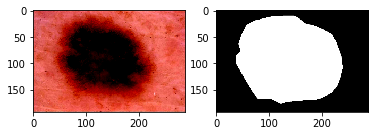

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


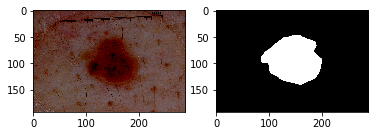

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


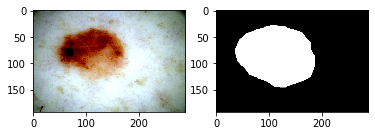

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


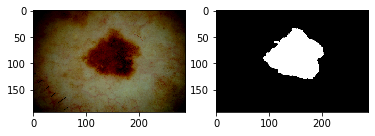

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


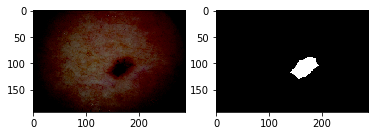

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


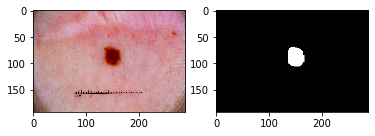

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


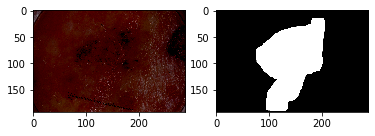

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


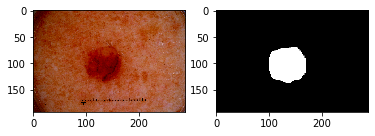

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


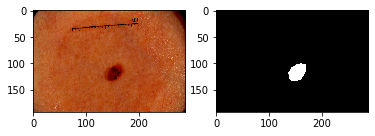

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


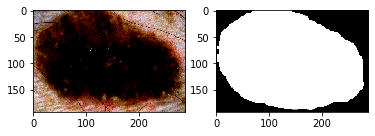

In [ ]:
crop_size=300
leng=2000
w=192
h=288
imgs=[]
masks=[]
images=[]
fig=plt.figure()

path="ISIC-2017_Training_Data"
mask_folder="ISIC-2017_Training_Part1_GroundTruth"
for idx in range(1,leng+1):
      file=img_name[idx]
      file+=".jpg"
      fullpath= os.path.join(path,file)
      msk=get_mask(file,mask_folder)
      msk=cv2.resize(msk,(h,w))
      #msk=center_crop(msk,crop_size=crop_size)
      masks.append(msk)
      image=cv2.imread(fullpath)
      #print(np.mean(image))
      if not os.path.exists(fullpath):
        #print("ok")
        continue
      image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image=image/127.5-1
      image=cv2.resize(image,(h,w))
      #image=center_crop(image,crop_size=crop_size)
      imgs.append(image)
      if idx%200 == 0:
        plt.figure(idx//50)
        plt.subplot(1,2,1).imshow(image,cmap='gray')
        plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
        plt.show()  

imgs=np.asarray(imgs,dtype=np.float)
masks=np.asarray(masks,dtype=np.float)


In [ ]:
print(imgs.shape)

(2000, 192, 288, 3)


In [ ]:
img_name_test=[]
with open('ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        img_name_test.append(row[0])
        
        
csvFile.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


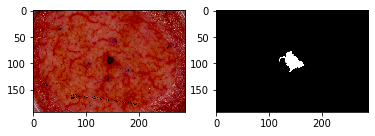

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


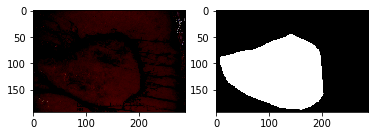

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


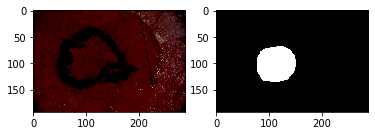

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


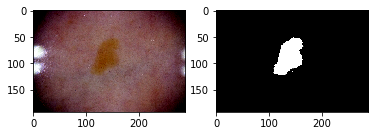

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


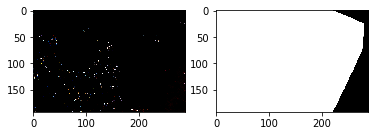

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


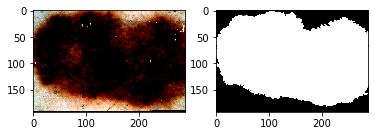

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


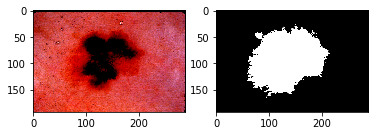

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


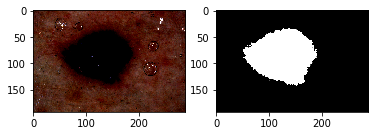

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


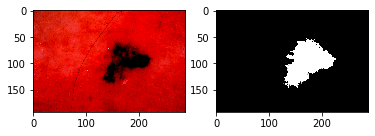

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


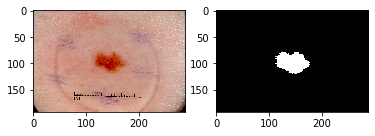

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


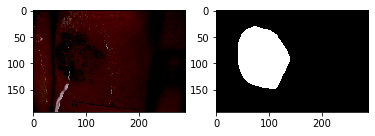

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


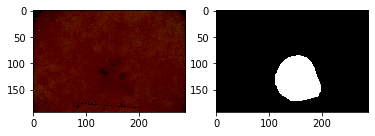

In [ ]:
leng=600
imgs_test=[]
masks_test=[]
#images_test=[]
path="ISIC-2017_Test_v2_Data"
mask_folder="ISIC-2017_Test_v2_Part1_GroundTruth"
for idx in range(1,leng+1):
      file=img_name_test[idx]
      file+=".jpg"
      fullpath= os.path.join(path,file)
      msk=get_mask(file,mask_folder)
      msk=cv2.resize(msk,(h,w))
      #msk=center_crop(msk,crop_size=crop_size)
      masks_test.append(msk)
      image=cv2.imread(fullpath)
      if not os.path.exists(fullpath):
        continue
      #print(idx,np.mean(image))
      #image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image=image/127.5-1
      image=cv2.resize(image,(h,w))
      #images_test.append(image)
      #images[idx-1]=image
      #image=center_crop(image,crop_size=crop_size)
      imgs_test.append(image)
      if idx%50 == 0:
        plt.figure(idx//50)
        plt.subplot(1,2,1).imshow(image,cmap='gray')
        plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
        plt.show()  

imgs_test=np.asarray(imgs_test,dtype=np.float)
masks_test=np.asarray(masks_test,dtype=np.float)

In [ ]:
masks=masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
masks_test=masks_test.reshape(masks_test.shape[0],masks_test.shape[1],masks_test.shape[2],1)
print(imgs.shape,masks.shape,imgs_test.shape,masks_test.shape)

(2000, 192, 288, 3) (2000, 192, 288, 1) (600, 192, 288, 3) (600, 192, 288, 1)


In [ ]:
np.random.seed(13)
index = np.random.permutation(imgs_test.shape[0])
img_dev=imgs_test[index[:600]]
mask_dev=masks_test[index[:600]]

In [ ]:
import keras
class lr_scheduler(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))

#loss

In [ ]:
from keras.losses import binary_crossentropy
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Data Augument

In [ ]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#Unet

In [ ]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None,):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2,  padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    conv6 = Lambda(mvn)(up6)
    conv6 = Activation('relu')(conv6)
    merge6 = concatenate([drop4,conv6], axis = 3)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = Conv2D(256, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    conv7 = Lambda(mvn)(up7)
    conv7 = Activation('relu')(conv7)
    merge7 = concatenate([conv3,conv7], axis = 3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(up7)

    up8 = Conv2D(128, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    conv8 = Lambda(mvn)(up8)
    conv8 = Activation('relu')(conv8)
    merge8 = concatenate([conv2,conv8], axis = 3)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = Conv2D(64, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    conv9 = Lambda(mvn)(up9)
    conv9 = Activation('relu')(conv9)
    merge9 = concatenate([conv1,conv9], axis = 3)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = data, output = conv10)

    model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = dice_coef_loss, metrics = ['accuracy',dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

#Deep_Lab

In [ ]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = Lambda(mvn)(x)
    #x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    x = Dropout(0.25)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = Lambda(mvn)(x)           
    #x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    #x = Lambda(mvn)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        #shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def deeplab_v3(input_shape = (192,288,3),classes=2,weights = None,):
      #config
      entry_block3_stride = 2
      middle_block_rate = 1
      exit_block_rates = (1, 2)
      atrous_rates = (6, 12, 18)

      #main
      #data = Input(shape=input_shape)
      img_input= Input(shape=input_shape,dtype=float)
      mvn0 = Lambda(mvn)(img_input)
      x = Conv2D(32, (3, 3), strides=(2, 2),
                      name='entry_flow_conv1_1', use_bias=False, padding='same')(mvn0)
      #x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
      x = Lambda(mvn)(x)
      x = Activation(tf.nn.relu)(x)

      x=Conv2D(64,(3, 3),strides=(1, 1),padding='same', use_bias=False,
                      dilation_rate=(1, 1),
                      name='entry_flow_conv1_2')(x)
      #x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
      x = Lambda(mvn)(x)
      #x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
      x = Activation(tf.nn.relu)(x)

      x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                          skip_connection_type='conv', stride=2,
                          depth_activation=False)
      x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                  skip_connection_type='conv', stride=2,
                                  depth_activation=False, return_skip=True)

      x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                          skip_connection_type='conv', stride=entry_block3_stride,
                          depth_activation=False)
      #x=deeplabv3.layers[35].output
      for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)
      x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                               skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                                depth_activation=False)
      x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                          skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                          depth_activation=True)
      # end of feature extraction



      #Atrous Spatial Pyramid Pooling
      # Image Feature branch
      shape_before = tf.shape(x)
      b4 = GlobalAveragePooling2D()(x)
      # from (b_size, channels)->(b_size, 1, 1, channels)
      b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
      b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
      b4 = Conv2D(256, (1, 1), padding='same',
                  use_bias=False, name='image_pooling')(b4)
      b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
      b4 = Activation(tf.nn.relu)(b4)
      # upsample. have to use compat because of the option align_corners
      size_before = tf.keras.backend.int_shape(x)
      b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                      method='bilinear', align_corners=True))(b4)
      # simple 1x1
      b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
      b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
      b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

      # all branches
      # rate = 6 (12)
      b1 = SepConv_BN(x, 256, 'aspp1',
                      rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
      # rate = 12 (24)
      b2 = SepConv_BN(x, 256, 'aspp2',
                      rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
      # rate = 18 (36)
      b3 = SepConv_BN(x, 256, 'aspp3',
                      rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

      # concatenate ASPP branches & project
      x = Concatenate()([b4, b0, b1, b2, b3])
      x = Conv2D(256, (1, 1), padding='same',
                  use_bias=False, name='concat_projection')(x)
      x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
      x = Activation(tf.nn.relu)(x)
      x = Dropout(0.25)(x)

      x=UpSampling2D((4,4))(x)
      #size_before2 = tf.keras.backend.int_shape(x)
      #x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
       #                                               skip1.shape[1:3],
       #                                               method='bilinear', align_corners=True))(x)

      dec_skip1 = Conv2D(48, (1, 1), padding='same',use_bias=False, name='feature_projection0')(skip1)
      #dec_skip1 = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
      dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
      x = Concatenate()([x, dec_skip1])
      x = SepConv_BN(x, 256, 'decoder_conv0',
                      depth_activation=True, epsilon=1e-5)
      x = SepConv_BN(x, 256, 'decoder_conv1',
                      depth_activation=True, epsilon=1e-5)
      #x = Conv2D(classes-1, (1, 1), padding='same', name="binary_class")(x)
      #size_before3 = tf.keras.backend.int_shape(img_input)
      #x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,size_before3[1:3], method='bilinear', align_corners=True))(x)
      x=UpSampling2D((4,4))(x)
      #x = Conv2D(2, 3,  padding = 'same')(x)
      #x = Activation('relu')(x)
      x = Conv2D(classes-1, (1, 1), padding='same', name="binary_class")(x)
      output=Activation("sigmoid")(x)
      model = Model(img_input, output, name='deeplabv3plus')
      model.compile(optimizer = SGD(lr = 0.001), loss =bce_dice_loss, metrics = ['accuracy',dice_coef])
      if not weights is None:
        model.load_weights(weights)
      #print(model.summary())
      return model

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

In [ ]:
from keras.callbacks import ModelCheckpoint
input_shape = (w, h, 3)
model = deeplab_v3(input_shape,2,'/content/deeplab_V3.46_0.81.hdf5')
#model.load_weights('weights.60_0.85.hdf5')
#print(model.evaluate(img_dev,mask_dev))
checkpoint = ModelCheckpoint('weights_save/deeplab_V3.{epoch:02d}_{val_dice_coef:.2f}.hdf5', monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
lr_decay = lr_scheduler()
callback_list = [checkpoint]
history = model.fit_generator(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 60, validation_data = (img_dev, mask_dev), callbacks = callback_list)



Epoch 1/60
500/500 [==============================] - 242s 484ms/step - loss: 0.2927 - acc: 0.9517 - dice_coef: 0.8429 - val_loss: 0.4945 - val_acc: 0.9216 - val_dice_coef: 0.8050

Epoch 00001: val_dice_coef improved from -inf to 0.80495, saving model to weights_save/deeplab_V3.01_0.80.hdf5
Epoch 2/60
500/500 [==============================] - 186s 372ms/step - loss: 0.2908 - acc: 0.9515 - dice_coef: 0.8430 - val_loss: 0.4944 - val_acc: 0.9215 - val_dice_coef: 0.8042

Epoch 00002: val_dice_coef did not improve from 0.80495
Epoch 3/60
500/500 [==============================] - 186s 373ms/step - loss: 0.2880 - acc: 0.9521 - dice_coef: 0.8439 - val_loss: 0.4942 - val_acc: 0.9215 - val_dice_coef: 0.8041

Epoch 00003: val_dice_coef did not improve from 0.80495
Epoch 4/60
500/500 [==============================] - 188s 375ms/step - loss: 0.2892 - acc: 0.9519 - dice_coef: 0.8443 - val_loss: 0.4931 - val_acc: 0.9215 - val_dice_coef: 0.8032

Epoch 00004: val_dice_coef did not improve from 0.8

In [ ]:
testt=np.expand_dims(img_dev[1],0)
model.load_weights("/content/weights_save/deeplab_V3.11_0.46.hdf5")
pre=model.predict(testt)
print(pre.shape)

In [ ]:
def plot_loss(losses):
    val_loss = [v[0] for v in history.history["val_loss"]]
    train_loss = [v[0] for v in history.history["loss"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="test loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
print(history.history)

#Evaluate

In [ ]:
model.load_weights('weights.03-0.29.hdf5')
model.evaluate(img_dev,mask_dev)

#Fit Generator


In [ ]:
nb_layers = [4, 5, 7, 10, 12, 15]
seed=123
input_shape = (w, h, 3)
num_classes = 2
model = Densenet55(input_shape)
model.load_weights('weights.24_0.83.hdf5')
kwargs = dict(
        rotation_range=180,
        zoom_range=0.1,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )
image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)

epochs = 50
mini_batch_size = 4

'''image_generator = image_datagen.flow(img_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
train_generator = izip(image_generator, mask_generator)'''
    
max_iter = (imgs.shape[0] // mini_batch_size) * epochs

curr_iter = 0
base_lr = K.eval(model.optimizer.lr)
lrate = lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5)
maxdice=0
for e in range(epochs):
        print('\nMain Epoch {:d}'.format(e+1))
        train_result = []
        for iteration in range(len(imgs)//mini_batch_size):
            img, mask = next(train_generator)
            res = model.train_on_batch(img, mask)
            curr_iter += 1
            lrate = lr_poly_decay(model, base_lr, curr_iter,
                                 max_iter, power=0.5)
            train_result.append(res)
        train_result = np.asarray(train_result)
        train_result = np.mean(train_result, axis=0).round(decimals=10)
        print("train_result: ",train_result)
        result = model.evaluate(img_dev, mask_dev, batch_size=32)
        result = np.round(result, decimals=10)
        if result[2]> maxdice:
          maxdice=result[2]
          epoch_max=e+1
          
        print('\nTest set result:', result)
        
        save_file = '_'.join(['ISIC2017_dense_',
                              'epoch', str(e+1)]) + '.h5'
        if not os.path.exists('model_logs'):
            os.makedirs('model_logs')
        save_path = os.path.join('model_logs', save_file)
        print('\nSaving model weights to {:s}'.format(save_path))
        model.save_weights(save_path)
        print(maxdice, epoch_max)

In [ ]:
import os

FJoin = os.path.join

def GetFiles(path):

    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list


files, dirs = GetFiles(os.path.expanduser("weights_save"))
for file in files:
    model.load_weights(file)
    print(model.evaluate(imgs,masks))


In [ ]:
plt.imshow(imgs[5])
plt.show()
plt.imshow(pred[5,:,:,0])
#plt.imshow(masks[5,:,:,0])

#build mat file

In [ ]:
import scipy.io as sio
path1="Matfile"
if not os.path.exists(path1):
            os.makedirs(path1)

for i in range(1,600):
  name1=img_name[i]
  matpath1= os.path.join(path1,name1)
  matpath1+=".mat"
  sio.savemat(matpath1, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})
  
path2="Matfile/Test"
if not os.path.exists(path2):
            os.makedirs(path2)
for i in range(n,leng):
  name2=img_name[i]
  matpath2= os.path.join(path2,name2)
  matpath2+=".mat"
  sio.savemat(matpath2, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})

In [ ]:
import shutil
shutil.make_archive('Matfile', 'zip',"Matfile")
